# Fine-tuning IndoBERT untuk Klasifikasi Emosi Twitter

In [1]:
# =====================================
# 1. Install library (sekali saja)
# =====================================
# !pip install transformers datasets scikit-learn pandas torch

In [2]:
# =====================================
# 2. Import library
# =====================================
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

d:\laragon\bin\python\python-3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# =====================================
# 3. Load dataset IndoNLU
# =====================================
train_url = "https://raw.githubusercontent.com/IndoNLP/indonlu/master/dataset/emot_emotion-twitter/train_preprocess.csv"
valid_url = "https://raw.githubusercontent.com/IndoNLP/indonlu/master/dataset/emot_emotion-twitter/valid_preprocess.csv"
test_url  = "https://raw.githubusercontent.com/IndoNLP/indonlu/master/dataset/emot_emotion-twitter/test_preprocess.csv"

train_df = pd.read_csv(train_url)
valid_df = pd.read_csv(valid_url)
test_df  = pd.read_csv(test_url)

In [4]:
# ==========================================
# 1. Load Dataset Meisa Putri (Github: meisaputri21)
# ==========================================
import pandas as pd

url_meisa = "https://raw.githubusercontent.com/meisaputri21/Indonesian-Twitter-Emotion-Dataset/master/Twitter_Emotion_Dataset.csv"
meisa_df = pd.read_csv(url_meisa)

print("Meisa Putri Dataset:")
print(meisa_df.head())
print("Label unik:", meisa_df['label'].unique())


Meisa Putri Dataset:
   label                                              tweet
0  anger  Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...
1  anger  Sesama cewe lho (kayaknya), harusnya bisa lebi...
2  happy  Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3  anger  Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...
4  happy  Sharing pengalaman aja, kemarin jam 18.00 bata...
Label unik: ['anger' 'happy' 'sadness' 'love' 'fear']


In [5]:
# ==========================================
# 2. Load Dataset Ricco48 (Gabungkan semua file, separator tab)
# ==========================================
import pandas as pd

urls_ricco = [
    "https://raw.githubusercontent.com/Ricco48/Emotion-Dataset-from-Indonesian-Public-Opinion/main/Emotion%20Dataset%20from%20Indonesian%20Public%20Opinion/AngerData.csv",
    "https://raw.githubusercontent.com/Ricco48/Emotion-Dataset-from-Indonesian-Public-Opinion/main/Emotion%20Dataset%20from%20Indonesian%20Public%20Opinion/FearData.csv",
    "https://raw.githubusercontent.com/Ricco48/Emotion-Dataset-from-Indonesian-Public-Opinion/main/Emotion%20Dataset%20from%20Indonesian%20Public%20Opinion/JoyData.csv",
    "https://raw.githubusercontent.com/Ricco48/Emotion-Dataset-from-Indonesian-Public-Opinion/main/Emotion%20Dataset%20from%20Indonesian%20Public%20Opinion/NeutralData.csv",
    "https://raw.githubusercontent.com/Ricco48/Emotion-Dataset-from-Indonesian-Public-Opinion/main/Emotion%20Dataset%20from%20Indonesian%20Public%20Opinion/LoveData.csv",
    "https://raw.githubusercontent.com/Ricco48/Emotion-Dataset-from-Indonesian-Public-Opinion/main/Emotion%20Dataset%20from%20Indonesian%20Public%20Opinion/SadData.csv"
]

ricco_dfs = []
for url in urls_ricco:
    df = pd.read_csv(url, sep="\t")  # separator tab
    ricco_dfs.append(df)

ricco_df = pd.concat(ricco_dfs, ignore_index=True)
# Rename kolom jadi konsisten
print("Ricco48 Dataset:")
print(ricco_df.head())
print("Label unik:", ricco_df['Label'].unique())


Ricco48 Dataset:
                                               Tweet  Label
0                        pagi2 udah di buat emosi :)  Anger
1  kok stabilitas negara, memange 10 thn negara t...  Anger
2                       dah lah emosi mulu liat emyu  Anger
3  aib? bodoh benar! sebelum kata aib itu muncul,...  Anger
4                            dih lu yg nyebelin bego  Anger
Label unik: ['Anger' 'Fear' 'Joy' 'Neutral' 'Love' 'Sad']


In [6]:
ricco_df = ricco_df.rename(columns={'Tweet': 'tweet', 'Label': 'label'})
ricco_df['label'] = ricco_df['label'].str.lower()

In [7]:
# ==========================================
# 3. Load /gerhardien/text-emotion-indonesia
# ==========================================
test_filtered_df = pd.read_csv("Dataset/test_filtered.csv")
train_filtered_df = pd.read_csv("Dataset/train_filtered.csv")
val_filtered_df = pd.read_csv("Dataset/val_filtered.csv")

gerhardien_df = pd.concat([train_filtered_df, val_filtered_df, test_filtered_df], ignore_index=True)
print("Gerhardien Dataset:")
print(gerhardien_df.head())
print("Label unik:", gerhardien_df['label'].unique())
# ==========================================


Gerhardien Dataset:
     label                                           sentence
0  sadness  aku telah belajar bahwa bahkan ketika aku mera...
1  sadness  aku tahu bagaimana rasanya menderita sakit dan...
2  neutral  Ucapkan selamat tinggal pada vas defferens dan...
3  neutral      Aku tak sabar menunggu Narratif ini berhenti.
4  neutral  Aku meninggalkannya karena aku mencoba untuk m...
Label unik: ['sadness' 'neutral' 'joy' 'anger']


In [9]:
gerhardien_df = gerhardien_df.rename(columns={'sentence': 'tweet'})
gerhardien_df['label'] = gerhardien_df['label'].str.lower()
print(gerhardien_df.head())

     label                                              tweet
0  sadness  aku telah belajar bahwa bahkan ketika aku mera...
1  sadness  aku tahu bagaimana rasanya menderita sakit dan...
2  neutral  Ucapkan selamat tinggal pada vas defferens dan...
3  neutral      Aku tak sabar menunggu Narratif ini berhenti.
4  neutral  Aku meninggalkannya karena aku mencoba untuk m...


In [10]:
# ==========================================
# 3. Standarisasi label & Gabungkan semua dataset (IndoNLU, Meisa, Ricco)
# ==========================================
# Standarisasi label ke lower case
meisa_df['label'] = meisa_df['label'].str.lower()
ricco_df['label'] = ricco_df['label'].str.lower()

# Gabungkan dengan dataset IndoNLU yang sudah ada (asumsi: train_df, valid_df, test_df sudah di-load)
# Kita hanya pakai kolom 'tweet' dan 'label'
all_df = pd.concat([
    train_df[['tweet', 'label']],
    valid_df[['tweet', 'label']],
    test_df[['tweet', 'label']],
    meisa_df[['tweet', 'label']],
    ricco_df[['tweet', 'label']],
    gerhardien_df[['tweet', 'label']]
], ignore_index=True)

print("Jumlah total data gabungan:", all_df.shape)
print("Contoh data:")
print(all_df.sample(10))
print("Label unik seluruh data:", all_df['label'].unique())


Jumlah total data gabungan: (29991, 2)
Contoh data:
                                                   tweet    label
13898                                kok sepi yakk tl gw  neutral
12577                           alhamdulillah kabar baik  neutral
21011  Aku sangat bersyukur karena merasa cemburu pad...    anger
16962  aku hanya merasa ingin membicarakannya tapi ak...      joy
27675     saya merasa begitu bersemangat tentang hal itu      joy
28119  aku merasa cukup penuh harapan pagi ini bahwa ...      joy
27725                           Aku merasa sangat letih.  sadness
6657   Romantis buat aing itu ketika melakukan apa ya...     love
7464   Aku pun boleh je nak jadi selfish, pemalas dan...    anger
18516  saya think saya mungkin merasa sedikit menyesa...  sadness
Label unik seluruh data: ['happy' 'anger' 'fear' 'sadness' 'love' 'joy' 'neutral' 'sad']


In [11]:
# ==========================================
# 4. Encoding Label pada Dataset Gabungan
# ==========================================
label_list = sorted(all_df['label'].unique())
label2id = {label: idx for idx, label in enumerate(label_list)}
id2label = {idx: label for label, idx in label2id.items()}

all_df['label'] = all_df['label'].map(label2id)

# Konversi ke HuggingFace Dataset
from datasets import Dataset
dataset_full = Dataset.from_pandas(all_df[['tweet', 'label']])

print(dataset_full)

Dataset({
    features: ['tweet', 'label'],
    num_rows: 29991
})


In [12]:
# ==========================================
# Split Dataset Gabungan Menjadi Train, Valid, dan Test (Stratified)
# ==========================================
from sklearn.model_selection import train_test_split

# Misal: dataframe hasil gabungan semua sumber adalah all_df
# pastikan kolomnya: 'tweet' dan 'label' (dalam bentuk angka, bukan string)
# Jika label masih string, pastikan lakukan mapping label2id terlebih dahulu!

# Split train+valid vs test (90% : 10%)
df_train_valid, df_test = train_test_split(
    all_df,
    test_size=0.10,
    stratify=all_df['label'],
    random_state=42
)

# Split train vs valid dari train+valid (80% train, 10% valid, 10% test total)
df_train, df_valid = train_test_split(
    df_train_valid,
    test_size=0.1111,   # 0.1111 x 0.90 ≈ 0.10 dari seluruh data
    stratify=df_train_valid['label'],
    random_state=42
)

print(f"Total data: {len(all_df)}")
print(f"Train: {len(df_train)}, Validasi: {len(df_valid)}, Test: {len(df_test)}")

# Jika ingin langsung convert ke HuggingFace Dataset:
from datasets import Dataset

train_dataset = Dataset.from_pandas(df_train.reset_index(drop=True))
valid_dataset = Dataset.from_pandas(df_valid.reset_index(drop=True))
test_dataset  = Dataset.from_pandas(df_test.reset_index(drop=True))

# Cek distribusi label pada masing-masing split
print("Distribusi label train:\n", df_train['label'].value_counts(normalize=True))
print("Distribusi label valid:\n", df_valid['label'].value_counts(normalize=True))
print("Distribusi label test:\n", df_test['label'].value_counts(normalize=True))


Total data: 29991
Train: 23992, Validasi: 2999, Test: 3000
Distribusi label train:
 label
7    0.208194
3    0.202484
0    0.183061
5    0.163513
1    0.073650
4    0.067814
2    0.067814
6    0.033469
Name: proportion, dtype: float64
Distribusi label valid:
 label
7    0.208069
3    0.202401
0    0.183061
5    0.163721
1    0.073691
4    0.068023
2    0.067689
6    0.033344
Name: proportion, dtype: float64
Distribusi label test:
 label
7    0.208333
3    0.202333
0    0.183000
5    0.163667
1    0.073667
2    0.068000
4    0.067667
6    0.033333
Name: proportion, dtype: float64


In [14]:
# =====================================
# 6. Load tokenizer & model dari lokal
# =====================================
# model_path = "./models/indobert-base-p1"

# tokenizer = BertTokenizer.from_pretrained(model_path)
# model = BertForSequenceClassification.from_pretrained(
#     model_path,
#     num_labels=len(label_list),
#     id2label=id2label,
#     label2id=label2id
# )

model_name = "indobenchmark/indobert-base-p1"

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

NameError: name 'init_empty_weights' is not defined

In [ ]:
# =====================================
# 7. Tokenisasi
# =====================================
def tokenize(batch):
    return tokenizer(batch['tweet'], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize, batched=True)
valid_dataset = valid_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/12705 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1588 [00:00<?, ? examples/s]

Map:   0%|          | 0/1589 [00:00<?, ? examples/s]

In [ ]:
# =====================================
# 8. TrainingArguments & Trainer
# =====================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions)
    }

training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-52-150475583>:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# =====================================
# 9. Training
# =====================================
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.051100,1.119224,0.841940
2,0.038600,1.115602,0.840050
3,0.000300,1.236431,0.840680


TrainOutput(global_step=2385, training_loss=0.05849994723187209, metrics={'train_runtime': 608.291, 'train_samples_per_second': 62.659, 'train_steps_per_second': 3.921, 'total_flos': 1283172837054864.0, 'train_loss': 0.05849994723187209, 'epoch': 3.0})

=== Classification Report ===
              precision    recall  f1-score   support

       anger       0.84      0.94      0.89       333
        fear       0.92      0.88      0.90       221
       happy       0.87      0.95      0.90       204
         joy       0.85      0.73      0.79       128
        love       0.84      0.89      0.86       204
     neutral       0.71      0.65      0.68       200
         sad       0.86      0.74      0.80       100
     sadness       0.93      0.87      0.90       199

    accuracy                           0.85      1589
   macro avg       0.85      0.83      0.84      1589
weighted avg       0.85      0.85      0.85      1589



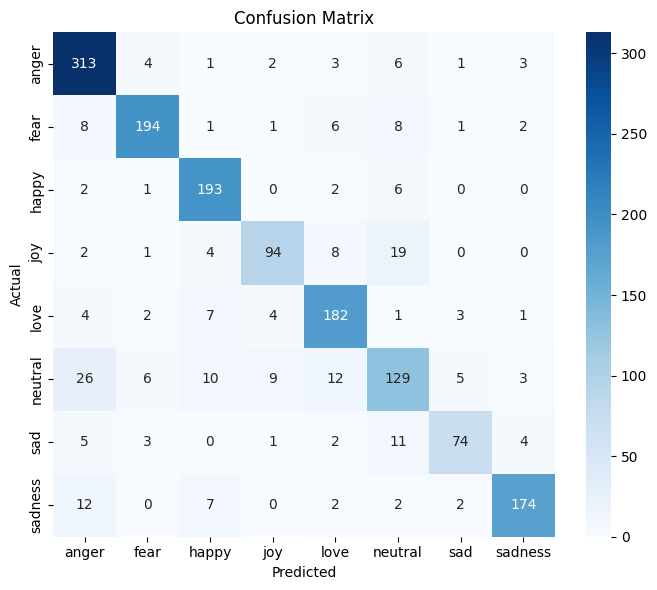

In [ ]:
# =====================================
# 10. Evaluasi Model
# =====================================
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Prediksi model
outputs = trainer.predict(test_dataset)
preds = np.argmax(outputs.predictions, axis=-1)

# Ambil label sebenarnya dari test_dataset
# Jika test_dataset adalah HuggingFace Dataset
y_true = np.array(test_dataset['label'])

# Tampilkan classification report
print("=== Classification Report ===")
print(classification_report(y_true, preds, target_names=label_list))

# Plot Confusion Matrix
cm = confusion_matrix(y_true, preds)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_list, yticklabels=label_list, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
# =====================================
# 11. Fungsi Deteksi Emosi (inference)
# =====================================
def detect_emotion(text: str):
    # Tentukan device yang digunakan (GPU jika ada, fallback ke CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Pindahkan model ke device
    model.to(device)
    model.eval()  # Pastikan dalam mode evaluasi

    # Tokenisasi dan pindahkan input ke device
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        pred_id = torch.argmax(outputs.logits, dim=1).item()

    return id2label[pred_id]


# Contoh penggunaan
print("Prediksi emosi:", detect_emotion("saya hari ini makan nasi"))

Prediksi emosi: sadness


In [ ]:
# =====================================
# 12. Simpan Model & Tokenizer
# =====================================
output_dir = "./emotion_model_v1"  # bisa diganti sesuai keinginan

# Simpan model
model.save_pretrained(output_dir)

# Simpan tokenizer
tokenizer.save_pretrained(output_dir)

# Simpan mapping label2id dan id2label (jika perlu, dalam format JSON)
import json

with open(f"{output_dir}/label2id.json", "w") as f:
    json.dump(label2id, f)
with open(f"{output_dir}/id2label.json", "w") as f:
    json.dump(id2label, f)

print(f"Model, tokenizer, dan mapping label berhasil disimpan ke folder: {output_dir}")


Model, tokenizer, dan mapping label berhasil disimpan ke folder: ./emotion_model_v1
